In [1]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import copy
from scipy.signal import butter, filtfilt
from scipy.signal import czt
from scipy.optimize import least_squares
from scipy.signal import spectrogram

In [2]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]


In [3]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

![Screenshot 2023-11-03 at 1.12.06 PM.png](<attachment:Screenshot 2023-11-03 at 1.12.06 PM.png>)
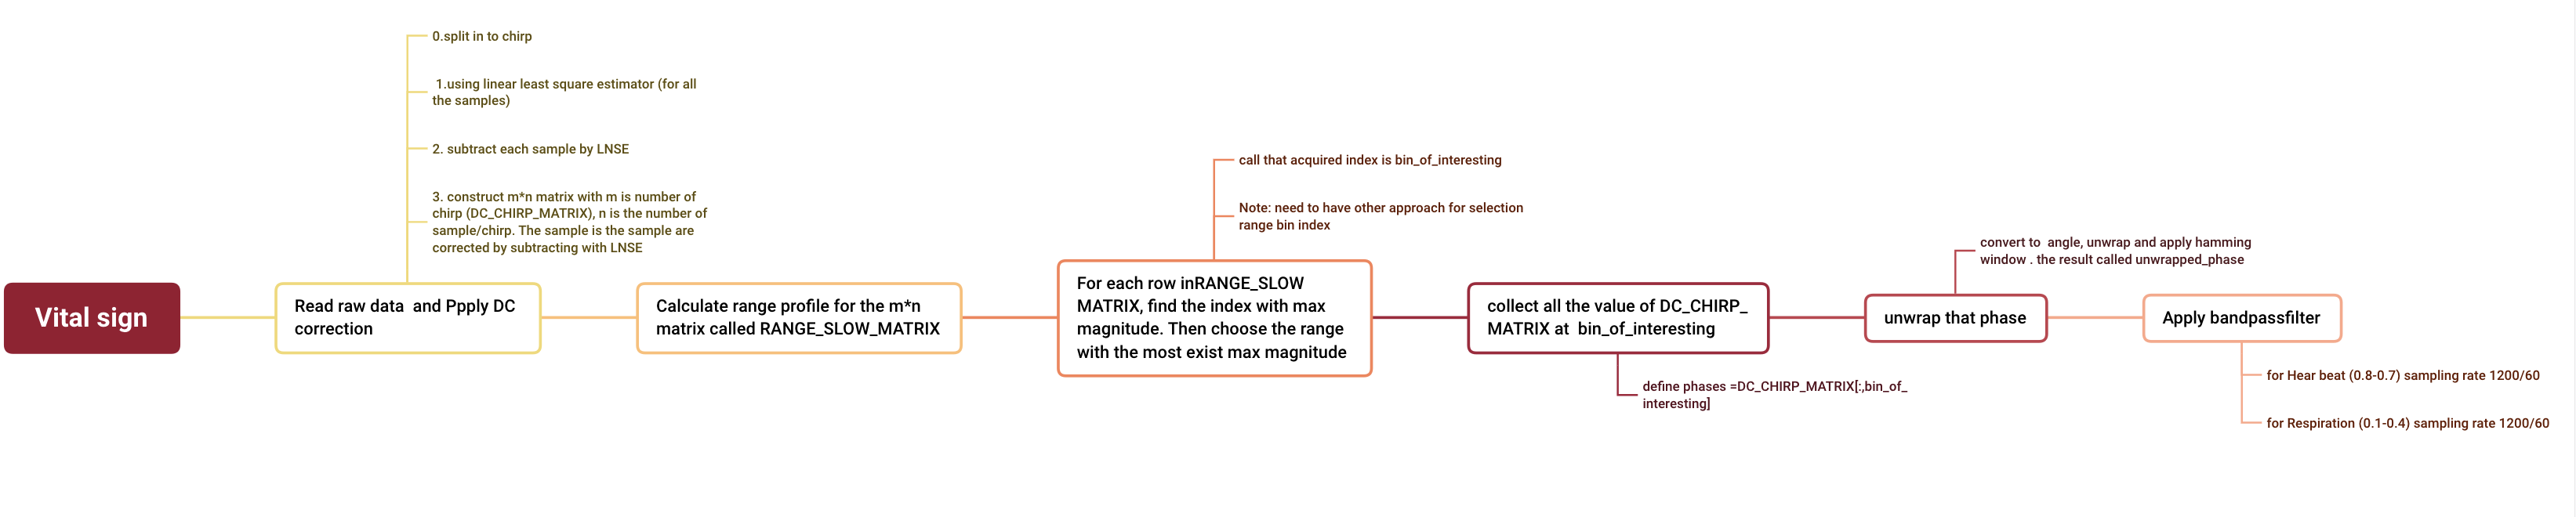

In [4]:
print(len(raw_data_channel_0))
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP*2] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP*2)]
first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 1)]
print(np.array(first_chirps_of_frame).shape)


3072000
(6000, 512)


In [5]:
def residuals(params, x1, x2):
    a, b, c = params
    return (x1 - a)**2 + (x2 - b)**2 - c

initial_params=np.array([0.5,0.5,0.5])
real_parts = []
imag_parts = []
IFchirps = np.array(first_chirps_of_frame).flatten()
for IFchirp in IFchirps:
    real_parts.append(IFchirp.real)
    imag_parts.append(IFchirp.imag)
r_result = least_squares(residuals, initial_params, args=(np.array(real_parts).flatten(), (np.array(imag_parts).flatten())))


In [6]:
a,b,c =r_result.x
DC_compensation =a+b*1j 
DC_corrected_chirps = [ (first_chirp -DC_compensation) for first_chirp in first_chirps_of_frame]

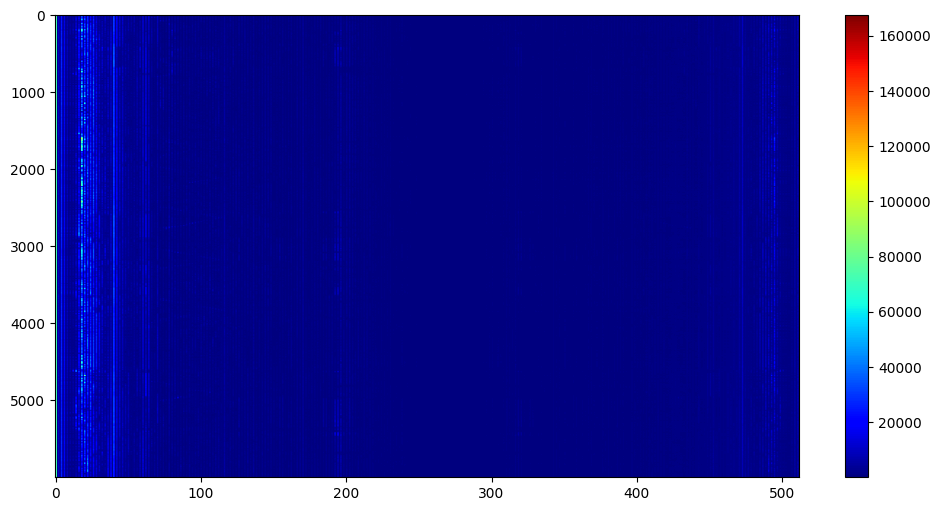

In [7]:
chirps_range_profiles = [np.fft.fft(chirp) for chirp in first_chirps_of_frame]
chirp_magnitudes = [np.abs(range_profile) for range_profile in chirps_range_profiles]

plt.figure(figsize=(12, 6))
plt.imshow(chirp_magnitudes,aspect='auto',cmap='jet')
plt.colorbar()
plt.show()

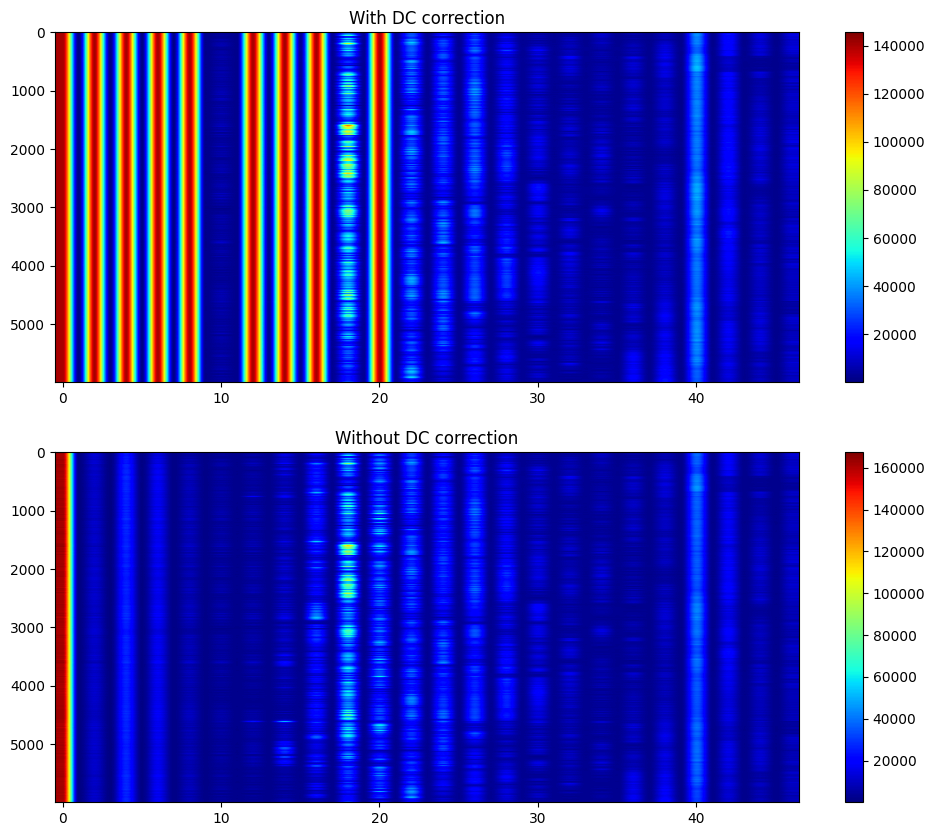

In [127]:
DC_corrected_chirps_range_profile = [np.fft.fft(DC_corrected_chirp) for DC_corrected_chirp in DC_corrected_chirps]
DC_corrected_magnitude = [np.abs(DC_corrected_chirps_fft) for DC_corrected_chirps_fft in DC_corrected_chirps_range_profile]


fft_chirps =[np.fft.fft(chirp) for chirp in first_chirps_of_frame]
abs_chirps =[np.abs(np.fft.fft(chirp)) for chirp in first_chirps_of_frame]



# for tmp_dc  in DC_corrected_magnitude:
#     tmp_dc[0]=140000
#     tmp_dc[2]=140000
#     tmp_dc[4]=140000
#     tmp_dc[6]=140000
#     tmp_dc[8]=140000
#     tmp_dc[12]=140000
#     tmp_dc[14]=140000
#     tmp_dc[16]=140000
#     tmp_dc[20]=140000


plt.figure(figsize=(12, 10))

plt.subplot(211)

plt.imshow(np.array(DC_corrected_magnitude)[:,0:47],aspect='auto',cmap='jet')
plt.title("With DC correction")
plt.colorbar()

plt.subplot(212)

plt.imshow(np.array(abs_chirps)[:,0:47],cmap='jet',aspect='auto')
plt.title("Without DC correction")
plt.colorbar()

plt.show()

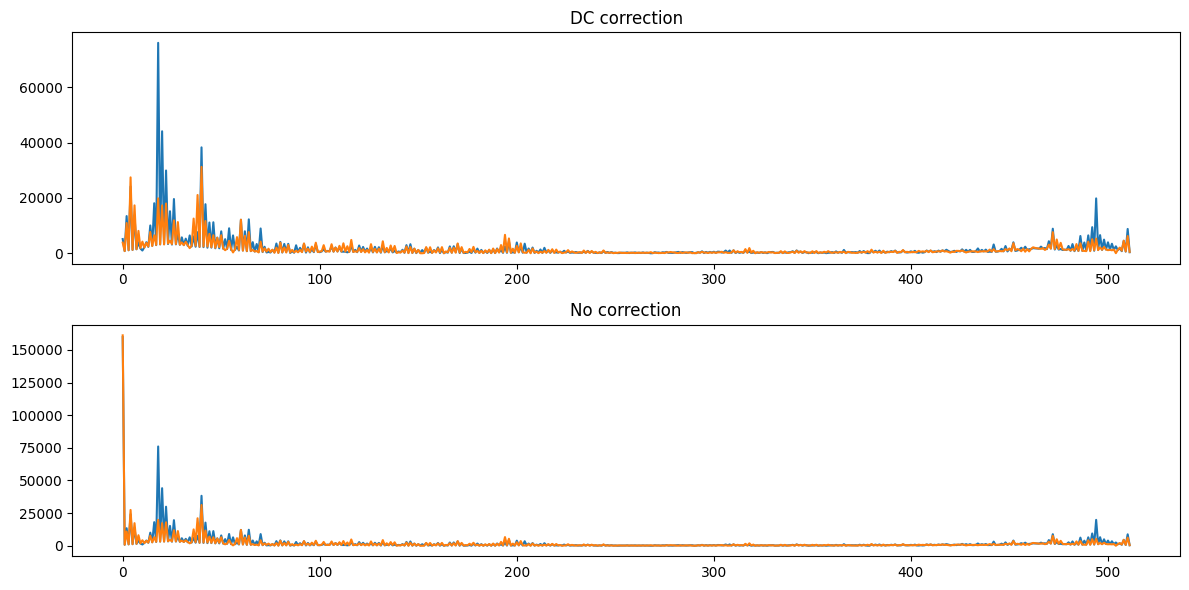

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(DC_corrected_magnitude[0])
plt.plot(DC_corrected_magnitude[-1])
plt.title("DC correction")

plt.subplot(2,1,2)
plt.plot(chirp_magnitudes[0])
plt.plot(chirp_magnitudes[-1])
plt.title("No correction")
plt.tight_layout()
plt.show()

(200,)


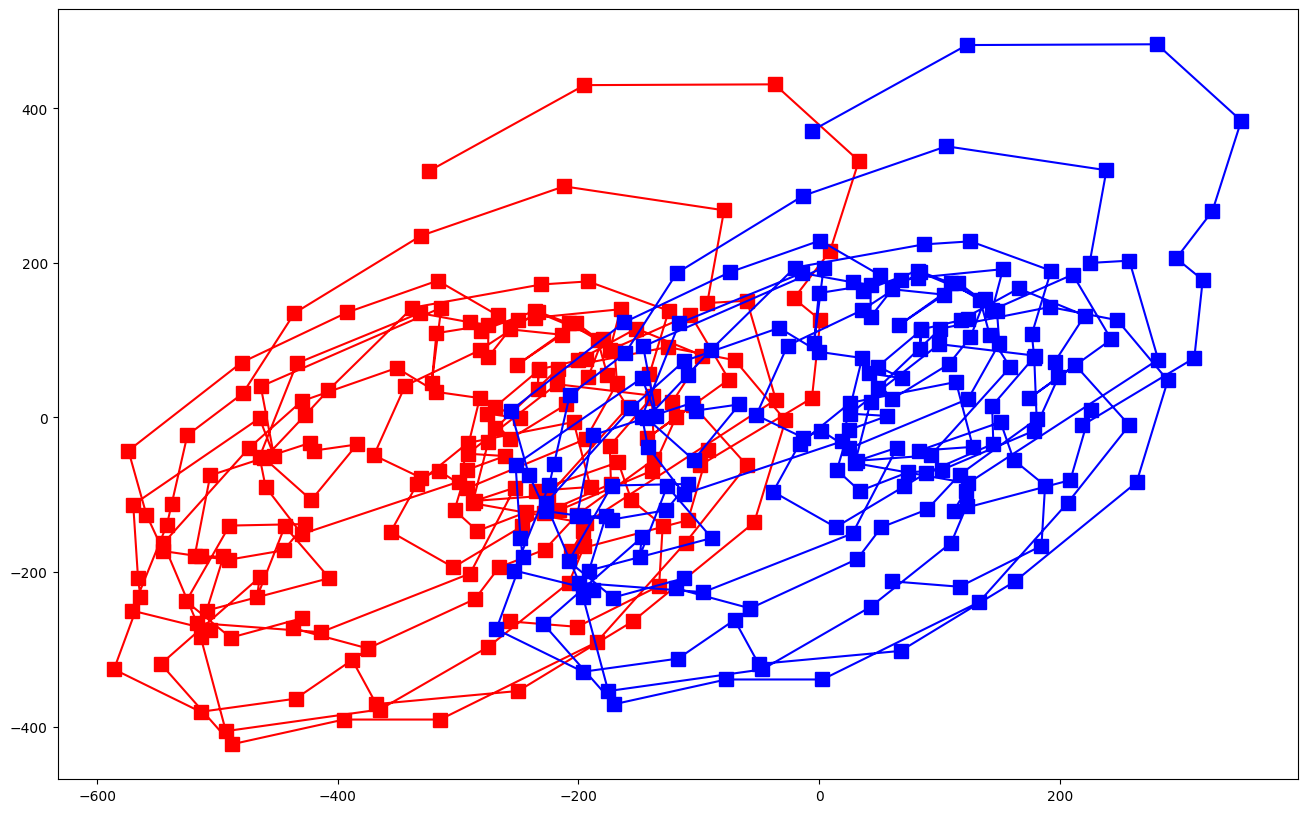

In [109]:

raw_chirps = (np.array(first_chirps_of_frame).flatten())[0:200]
raw_chirps_real = [raw_chirp.real for raw_chirp in raw_chirps]
raw_chirps_image = [raw_chirp.imag for raw_chirp in raw_chirps]

print( np.array(raw_chirps_real).shape)

dc_chirps  =(np.array(DC_corrected_chirps).flatten()) [0:200]
DC_corrected_real = [dc_chirp.real for dc_chirp in dc_chirps]
DC_corrected_image =[dc_chirp.imag for dc_chirp in dc_chirps]

plt.figure(figsize=(16, 10))

plt.plot(raw_chirps_real, raw_chirps_image, 'rs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(raw_chirps_real, raw_chirps_image, color='red')

plt.plot(DC_corrected_real, DC_corrected_image, 'bs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(DC_corrected_real, DC_corrected_image, color='blue')

plt.show()


In [11]:
magnitude_index = np.zeros(shape=len(DC_corrected_magnitude))
for  magnitude_spectrum in DC_corrected_magnitude:
    magnitude = np.abs(magnitude_spectrum)
    max_index=np.argmax(magnitude_spectrum[0:-1])
    # max_value = max(magnitude[1:-1])
    # max_index = np.where(max_value == magnitude)[0]
    magnitude_index[max_index]+=1
max_bin = max(magnitude_index)
bin_of_interest = np.where(max_bin ==magnitude_index )[0]

for i,val in enumerate(magnitude_index):
    if(0!=val):
        print("index:",i," : ",val)
print("bin of interest: ",bin_of_interest)

index: 14  :  38.0
index: 16  :  153.0
index: 18  :  2731.0
index: 20  :  837.0
index: 22  :  502.0
index: 24  :  186.0
index: 26  :  53.0
index: 40  :  1500.0
bin of interest:  [18]


In [12]:

interested_bin_phase =np.array(DC_corrected_chirps)[:,bin_of_interest]
interested_bin_angle =np.unwrap(np.angle(interested_bin_phase))

windowed_signal = interested_bin_angle.flatten() * np.hanning(len(interested_bin_angle))
hamming_windowed_signal = interested_bin_angle.flatten() * np.hamming(len(interested_bin_angle))



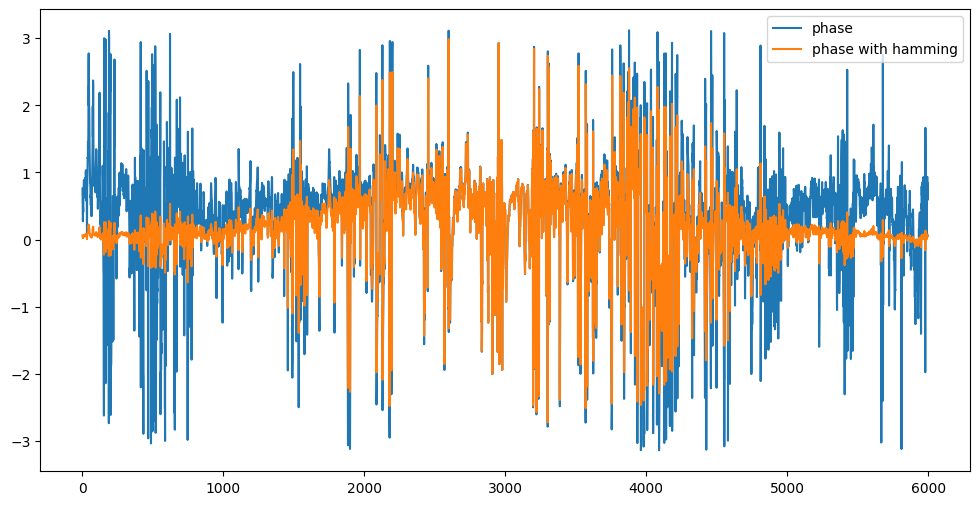

In [13]:
plt.figure(figsize=(12,6))
plt.plot(interested_bin_angle,label='phase')

plt.plot(hamming_windowed_signal,label='phase with hamming')
# plt.plot(windowed_signal,label='phase with hanning')

plt.legend()
plt.show()

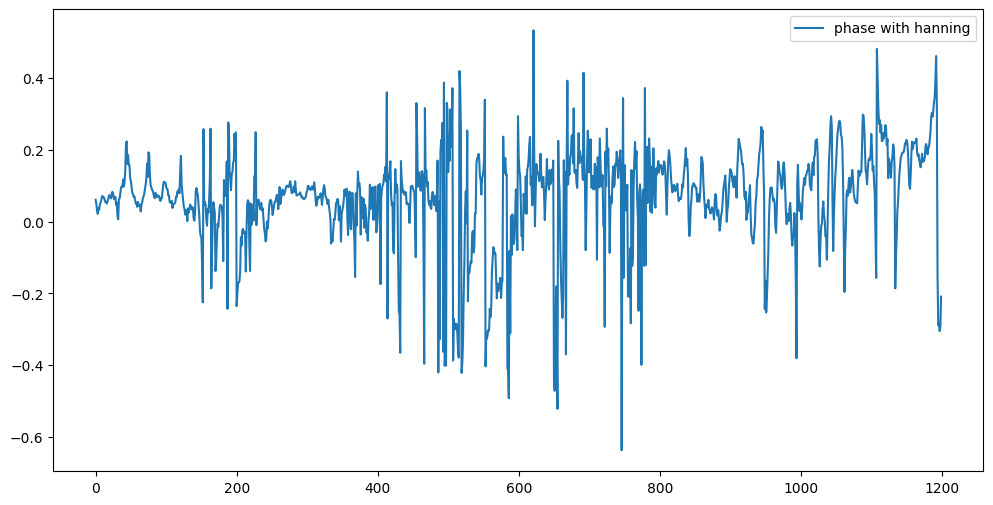

In [14]:
plt.figure(figsize=(12,6))
plt.plot(hamming_windowed_signal[0:1200],label='phase with hanning')
plt.legend()
plt.show()

/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


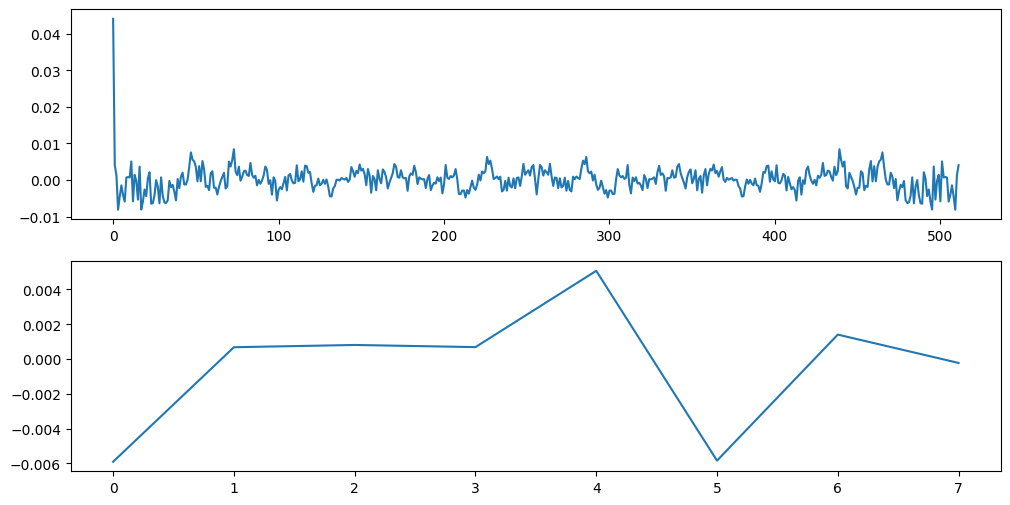

In [15]:
freq =np.fft.fft(hamming_windowed_signal[0:1200],512)
fft_resolution  = 1/600

plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(freq*fft_resolution)

plt.subplot(212)
plt.plot(freq[7:15]*fft_resolution)
plt.show()

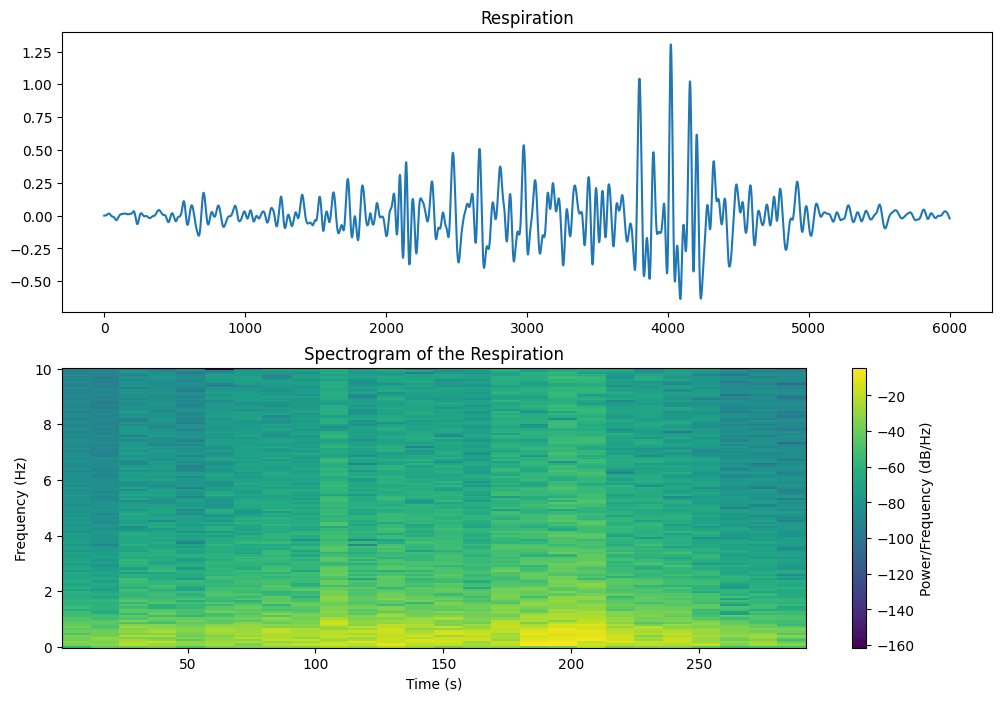

In [105]:
sampling_rate = 1200/60# Sampling rate of the input signal
low_freq = 0.1  # Lower cutoff frequency of the bandpass filter
high_freq = 0.4  # Upper cutoff frequency of the bandpass filter
filter_order = 4  # Order of the bandpass filter

# Compute the normalized cutoff frequencies
nyquist_freq = 0.5 * sampling_rate
low_norm = low_freq / nyquist_freq
high_norm = high_freq / nyquist_freq

# Design the bandpass filter
b, a = signal.butter(filter_order, [low_norm, high_norm], btype='band')

# Apply the bandpass filter to the input signal
filtered_signal = signal.lfilter(b, a, hamming_windowed_signal)
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(filtered_signal)
plt.title("Respiration")

magnitude_signal = np.abs(filtered_signal)
# Compute the spectrogram
f, t, Sxx = spectrogram(magnitude_signal, fs=sampling_rate)

# Convert magnitude to dB scale for better visualization
Sxx_db = 10 * np.log10(Sxx)

# Plot the spectrogram
plt.subplot(2,1,2)
plt.pcolormesh(t, f, Sxx_db)
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('Spectrogram of the Respiration')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()




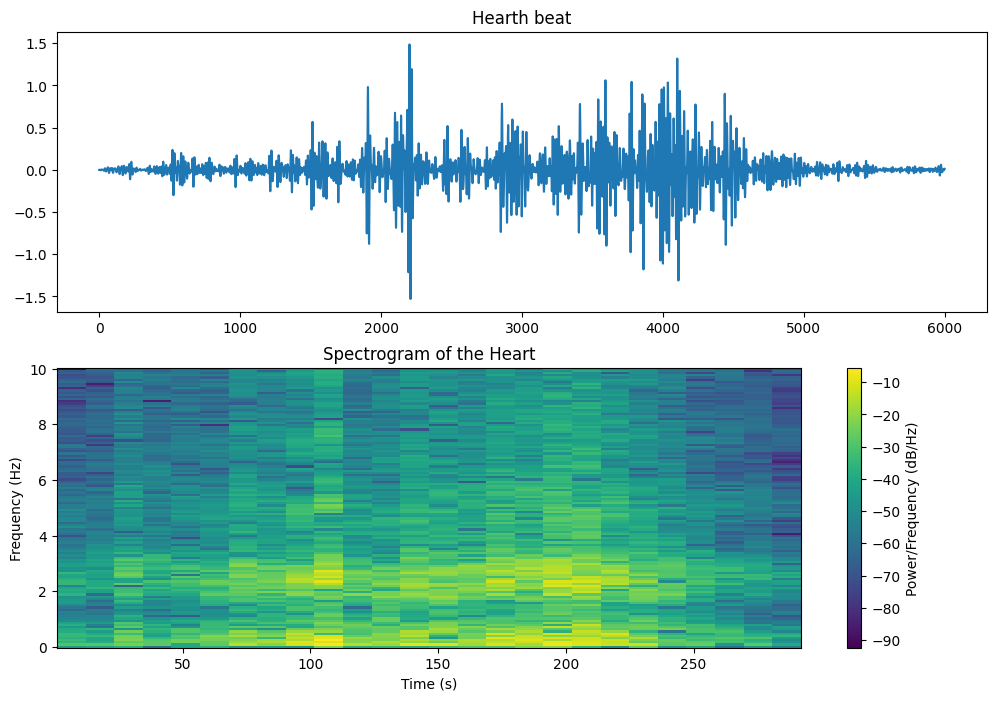

In [31]:

sampling_rate = 1200/60# Sampling rate of the input signal
low_freq = 0.8  # Lower cutoff frequency of the bandpass filter
high_freq = 1.7  # Upper cutoff frequency of the bandpass filter
filter_order = 4  # Order of the bandpass filter

# Compute the normalized cutoff frequencies
nyquist_freq = 0.5 * sampling_rate
low_norm = low_freq / nyquist_freq
high_norm = high_freq / nyquist_freq

# Design the bandpass filter
b, a = signal.butter(filter_order, [low_norm, high_norm], btype='band')

# Apply the bandpass filter to the input signal
heart_filtered_signal = signal.lfilter(b, a, hamming_windowed_signal)
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(heart_filtered_signal)
plt.title("Hearth beat")

heart_magnitude_signal = np.abs(heart_filtered_signal)
# Compute the spectrogram
f, t, Sxx = spectrogram(heart_magnitude_signal, fs=sampling_rate)

# Convert magnitude to dB scale for better visualization
Sxx_db = 10 * np.log10(Sxx)

# Plot the spectrogram
plt.subplot(2,1,2)
plt.pcolormesh(t, f, Sxx_db)
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('Spectrogram of the Heart')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()



(512,)
(13,)


/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


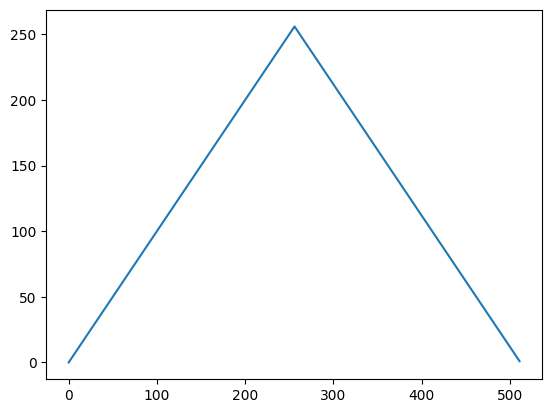

In [61]:
window = 'hann'  # Windowing function (e.g., Hann window)
nperseg = 512  # Number of samples per segment
noverlap = 0  # Number of overlapping samples between segments

# Compute the STFT
frequencies, times, Zxx = signal.stft(np.array(DC_corrected_chirps)[:,0], fs=512, window=window, nperseg=nperseg, noverlap=noverlap)
# plt.plot(frequencies,times)
print((frequencies).shape)
print((times).shape)
plt.plot(np.abs(frequencies))